In [1]:
import osmnx as ox
import matplotlib.pyplot as plt

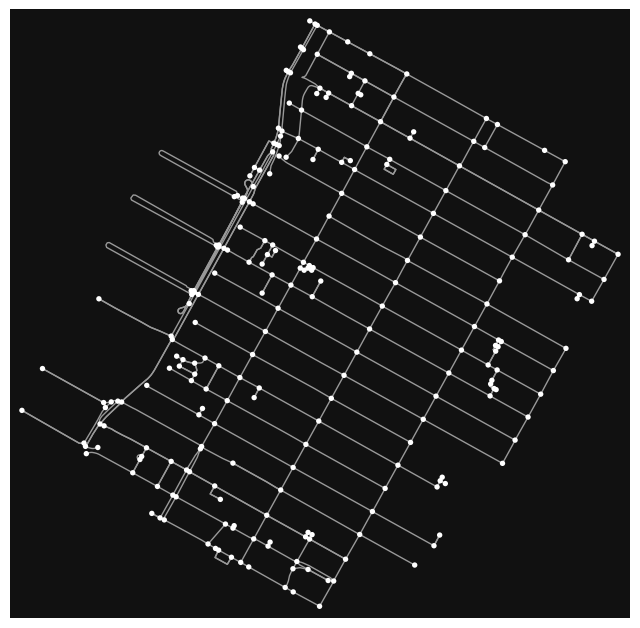

In [2]:
#Tworzymy mapę dzielnicy Hell's Kitchen w Manhattanie, wyświetlając drogi, po których możemy poruszać się rowerem
place = "Hell's Kitchen, Manhattan, New York City, New York, United States of America"
graph = ox.graph_from_place(place, network_type="bike")
fig, ax = ox.plot_graph(graph)

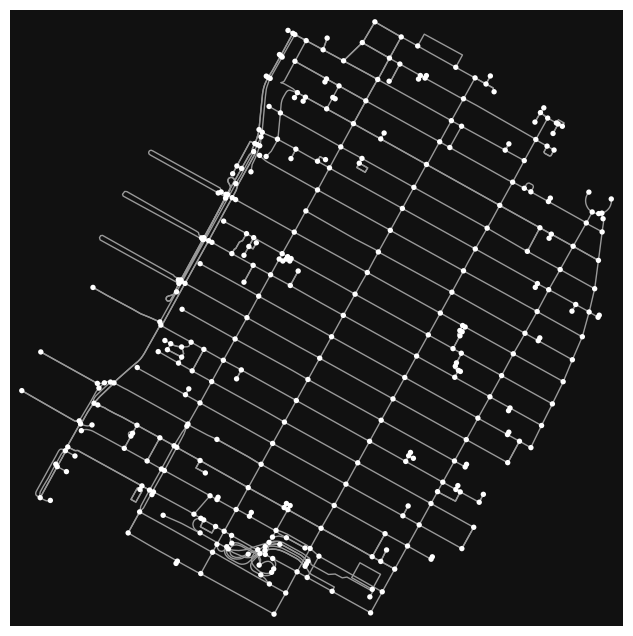

In [5]:
#Powiększmy obszar aby uniknąć wychodzenia najbliższej trasy (która będzie później obliczana) poza obszar

place_polygon = ox.geocode_to_gdf(place)

# aby jednostką CRS były metry:
place_polygon = place_polygon.to_crs("EPSG:3067")

# zwiększamy obszar o 300m
place_polygon["geometry"] = place_polygon.buffer(300)

# powrót do WGS84 (wymagane przez bibliotekę omnsx)
place_polygon = place_polygon.to_crs("EPSG:4326")

graph = ox.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="bike"
)

fig, ax = ox.plot_graph(graph)

In [6]:
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid  oneway              name      highway  \
u        v          key                                                     
42421974 7551756705 0      5669002    True  West 61st Street  residential   
         5481875128 0    570152306   False               NaN      service   
         1241742627 0    938601996    True   Columbus Avenue      primary   
42421982 6458959584 0    809013919   False  West 61st Street  residential   
42421985 3371304373 0     46525011    True  West 61st Street     tertiary   

                        reversed  length  \
u        v          key                    
42421974 7551756705 0      False  32.591   
         5481875128 0      False  29.686   
         1241742627 0      False  79.990   
42421982 6458959584 0       True  40.981   
42421985 3371304373 0      False  61.445   

                                                                  geometry  \
u        v          key                                                      
42421974 7551756705 0    LINESTRING (-73.98386 40.77048, -73.98373 40.7...   
         5481875128 0    LINESTRING (-73.98386 40.77048, -73.98399 40.7...   
         1241742627 0    LINESTRING (-73.98386 40.77048, -73.98390 40.7...   
42421982 6458959584 0    LINESTRING (-73.98668 40.77166, -73.98656 40.7...   
42421985 3371304373 0    LINESTRING (-73.98954 40.77286, -73.98941 40.7...   

                        lanes maxspeed access width bridge tunnel est_width  \
u        v          key                                                       
42421974 7551756705 0     NaN      NaN    NaN   NaN    NaN    NaN       NaN   
         5481875128 0     NaN      NaN    NaN   NaN    NaN    NaN       NaN   
         1241742627 0       3   25 mph    yes   NaN    NaN    NaN       NaN   
42421982 6458959584 0       2   25 mph    NaN   NaN    NaN    NaN       NaN   
42421985 3371304373 0       1      NaN    NaN   NaN    NaN    NaN       NaN   

                        service  ref junction  
u        v          key                        
42421974 7551756705 0       NaN  NaN      NaN  
         5481875128 0       NaN  NaN      NaN  
         1241742627 0       NaN  NaN      NaN  
42421982 6458959584 0       NaN  NaN      NaN  
42421985 3371304373 0       NaN  NaN      NaN

In [8]:
# Zmieniamy układ współrzędnych na UTM
graph = ox.project_graph(graph) 

# wyodrębniamy
nodes, edges = ox.graph_to_gdfs(graph)

nodes.crs

<Derived Projected CRS: +proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
ox.basic_stats(graph)

{'n': 380,
 'm': 701,
 'k_avg': 3.6894736842105265,
 'edge_length_total': 60015.97300000005,
 'edge_length_avg': 85.61479743223973,
 'streets_per_node_avg': 2.886842105263158,
 'streets_per_node_counts': {0: 0, 1: 82, 2: 13, 3: 155, 4: 126, 5: 4},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.21578947368421053,
  2: 0.034210526315789476,
  3: 0.40789473684210525,
  4: 0.33157894736842103,
  5: 0.010526315789473684},
 'intersection_count': 298,
 'street_length_total': 49123.516000000025,
 'street_segment_count': 531,
 'street_length_avg': 92.51132956685504,
 'circuity_avg': 1.0737568139936289,
 'self_loop_proportion': 0.005649717514124294}

In [16]:
from_loc = (
    ox.geocode_to_gdf("Hell's Kitchen, Manhattan")  # adres
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

to_loc = (
    ox.geocode_to_gdf("Sacred heart of jesus school, Manhattan")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

In [17]:
#Szukamy punktów rozpoczęcia trasy oraz zakończenia

from_node = ox.nearest_nodes(graph, from_loc.x, from_loc.y)
from_node

5481839792

In [18]:
to_node = ox.nearest_nodes(graph, to_loc.x, to_loc.y)
to_node

42446363

In [19]:
#szukamy najbliższej drogi

path = ox.shortest_path(graph, from_node, to_node)
path

[5481839792, 42440170, 42454042, 42446363]

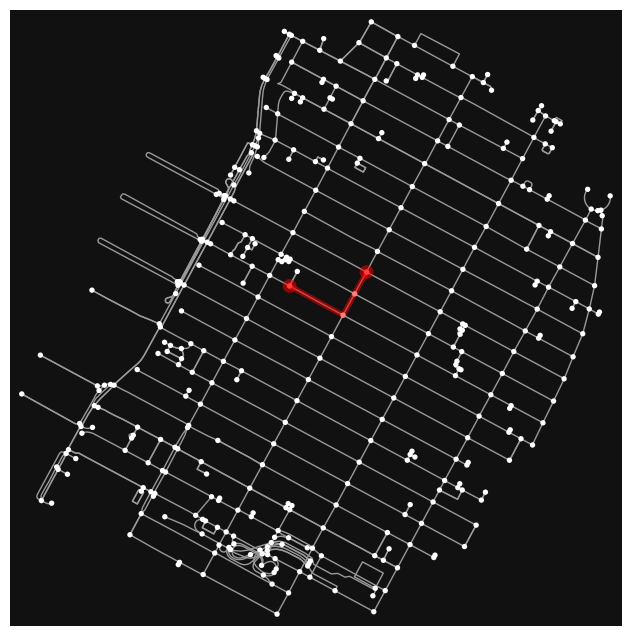

In [20]:
fig, ax = ox.plot_graph_route(graph, path)

In [21]:
#A następnie to samo, ale ze szkoły do Belvedere hotel
from_loc = (
    ox.geocode_to_gdf("Sacred heart of jesus school, Manhattan")  # adres
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

to_loc = (
    ox.geocode_to_gdf("Belvedere Hotel, Manhattan")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

In [22]:
#Szukamy punktów rozpoczęcia trasy oraz zakończenia

from_node = ox.nearest_nodes(graph, from_loc.x, from_loc.y)
from_node

42446363

In [23]:
to_node = ox.nearest_nodes(graph, to_loc.x, to_loc.y)
to_node

42435680

In [24]:
#szukamy najbliższej drogi

path = ox.shortest_path(graph, from_node, to_node)
path

[42446363, 42445027, 42445025, 42440163, 42432594, 42443532, 42435680]

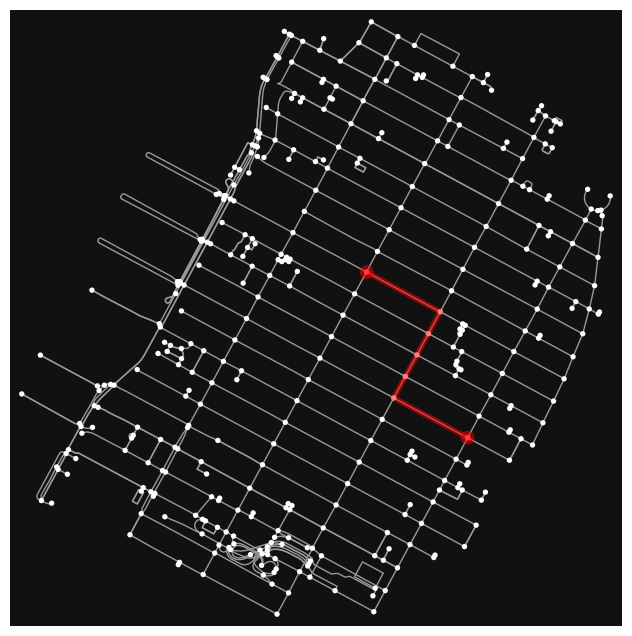

In [25]:
fig, ax = ox.plot_graph_route(graph, path)

<AxesSubplot: >

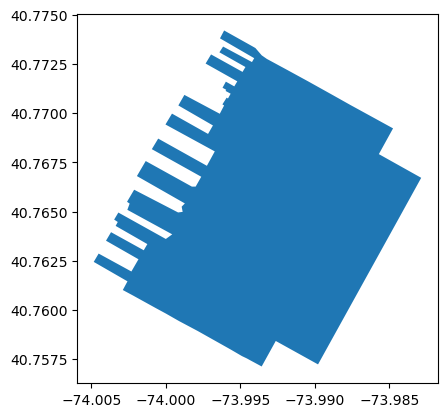

In [30]:
area = ox.geocode_to_gdf(place)
area.plot()

<AxesSubplot: >

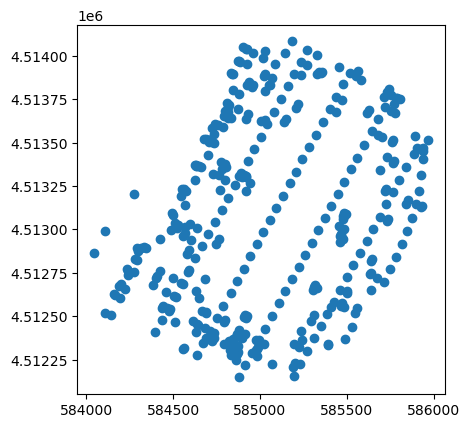

In [32]:
nodes.plot()

In [38]:
#Tworzymy zmienne, dzięki którym będziemy mogli wyodrębnić i zobaczyć miejsca takie jak hotele, sklepy oraz parki (z trawą)
t = {"tourism":"hotel"}
hotels = ox.geometries_from_address(place, tags=t)

t = {"shop":"yes"}
shops = ox.geometries_from_address(place, tags=t)

parks = ox.geometries_from_place(
    place,
    {
        "leisure": "park",
        "landuse": "grass",
    },
)

In [47]:
nodes, edges = ox.graph_to_gdfs(graph)

<AxesSubplot: >

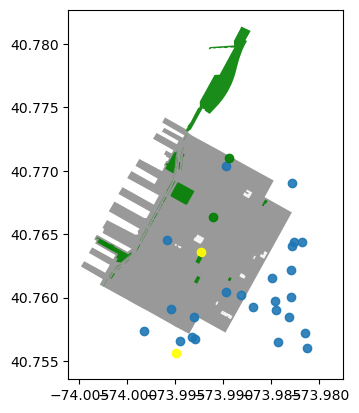

In [51]:
fig, ax = plt.subplots()
area.plot(ax=ax, facecolor='black', alpha=0.4)
hotels.plot(ax=ax, facecolor='white', alpha=0.9)
shops.plot(ax=ax, facecolor='yellow', alpha=0.9)
parks.plot(ax=ax, color='green', alpha=0.9)

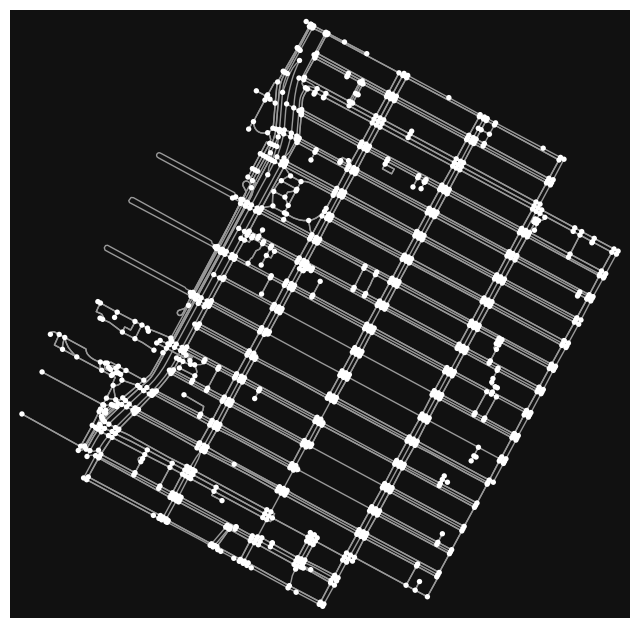

In [54]:
#Obliczymy obszar dzielnicy
graph = ox.graph_from_place(place)
graph_projection = ox.project_graph(graph)
fig, ax = ox.plot_graph(graph_projection)

In [60]:
edges = ox.graph_to_gdfs(graph_projection, nodes=False, edges=True)
# obliczam powierzchnię Hell's Kitchen
area = edges.unary_union
area

AttributeError: 'MultiLineString' object has no attribute 'plot'

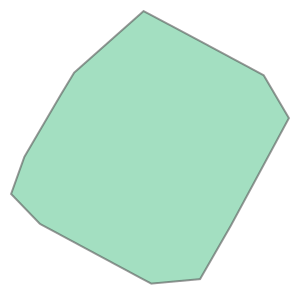

In [57]:
area = edges.unary_union.convex_hull
area

In [58]:
#Powierzchnia wynosi:
area = edges.unary_union.convex_hull.area
area

1980216.9270272152